In [37]:
import numpy as np

left_outputs = np.load("/workspace/data/sam3d_body_results/run_3/osmo_1_sam_3d_body_outputs.npz", allow_pickle=True)['outputs']
right_outputs = np.load("/workspace/data/sam3d_body_results/run_3/osmo_2_sam_3d_body_outputs.npz", allow_pickle=True)['outputs']

In [38]:
left_outputs[0].keys()

dict_keys(['bbox', 'focal_length', 'pred_keypoints_3d', 'pred_keypoints_2d', 'pred_vertices', 'pred_cam_t', 'pred_pose_raw', 'global_rot', 'body_pose_params', 'hand_pose_params', 'scale_params', 'shape_params', 'expr_params', 'mask', 'pred_joint_coords', 'pred_global_rots', 'lhand_bbox', 'rhand_bbox', 'frame'])

In [39]:
len(left_outputs)

360

In [40]:
for k, v in left_outputs[0].items():
	if isinstance(v, np.ndarray):
		print(k, v.shape)
	elif v is None:
		print(k, v)

bbox (4,)
pred_keypoints_3d (70, 3)
pred_keypoints_2d (70, 2)
pred_vertices (18439, 3)
pred_cam_t (3,)
pred_pose_raw (266,)
global_rot (3,)
body_pose_params (133,)
hand_pose_params (108,)
scale_params (28,)
shape_params (45,)
expr_params (72,)
mask None
pred_joint_coords (127, 3)
pred_global_rots (127, 3, 3)
lhand_bbox (4,)
rhand_bbox (4,)
frame (1080, 1920, 3)


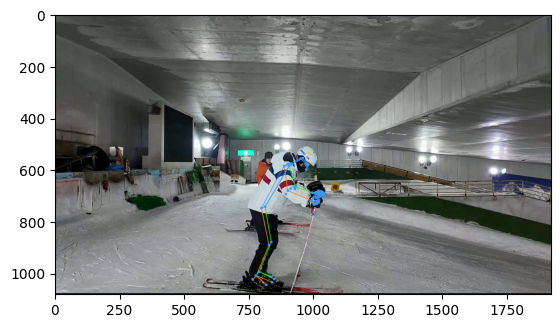

In [41]:
# draw left and right 3d pose in one plot 
# 连线
import sys
import os
import matplotlib.pyplot as plt

parent_dir = os.path.dirname(os.getcwd()) 
sys.path.insert(0, parent_dir)

one_sample = left_outputs[0]
img_vis = one_sample["frame"].copy()

from sam3d_body.infer import setup_visualizer
from sam3d_body.vis import (
    visualize_2d_results, visualize_3d_mesh,
    display_results_grid, 
)

# Set up visualizer
visualizer = setup_visualizer()


# Draw keypoints
keypoints_2d = one_sample["pred_keypoints_2d"]
keypoints_2d_vis = np.concatenate(
	[keypoints_2d, np.ones((keypoints_2d.shape[0], 1))], axis=-1
)
img_vis = visualizer.draw_skeleton(img_vis, keypoints_2d_vis)

plt.imshow(img_vis)


(70, 3)


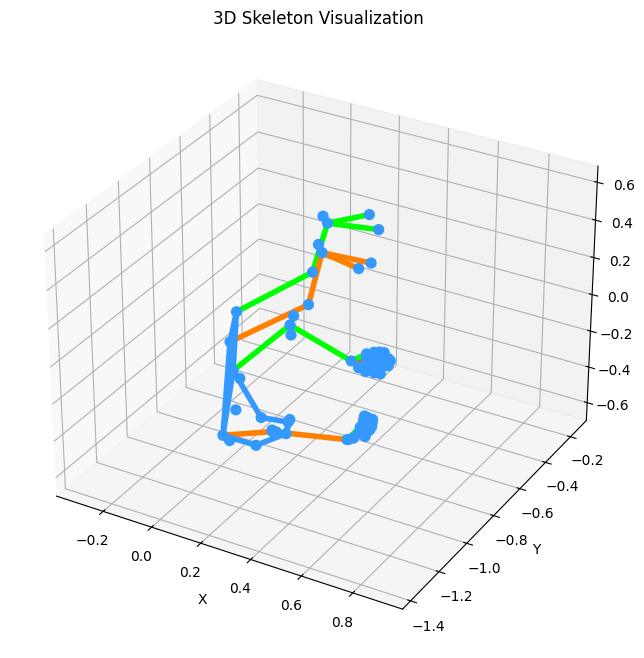

In [42]:
keypoints_3d = one_sample["pred_keypoints_3d"]

print(keypoints_3d.shape)
fig_3d = visualizer.draw_skeleton_3d(keypoints_3d)

fig_3d.show()

left_outputs
[-0.45446438  1.5032961   2.993183  ]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.11190611  0.15946792  0.98083985]
  [-0.10842217  0.9831064  -0.1474663 ]
  [-0.9877862  -0.08984241  0.12730551]]

 [[ 0.1609256  -0.9826135   0.09259462]
  [-0.9859548  -0.16429856 -0.02998659]
  [ 0.04467838 -0.08646849 -0.9952523 ]]

 ...

 [[ 0.10167468  0.8932296   0.43795338]
  [ 0.09566197  0.42941606 -0.898026  ]
  [-0.99020755  0.13320199 -0.04178739]]

 [[ 0.10167468  0.8932296   0.43795338]
  [ 0.09566197  0.42941606 -0.898026  ]
  [-0.99020755  0.13320199 -0.04178739]]

 [[ 0.89322954  0.426067    0.14355421]
  [ 0.42941606 -0.903068    0.00836194]
  [ 0.13320196  0.05417535 -0.98960716]]]
right_outputs
[-0.03981623  1.0632429   2.1117475 ]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[-0.07588461 -0.17705134 -0.9812718

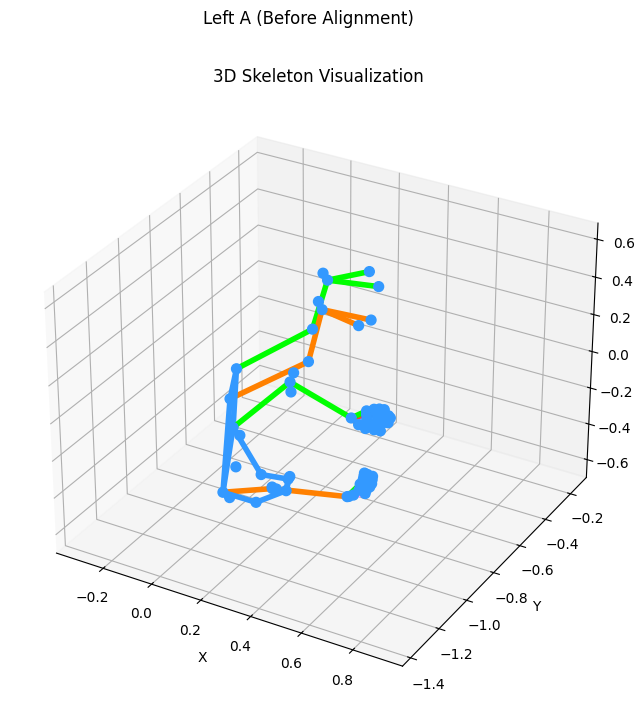

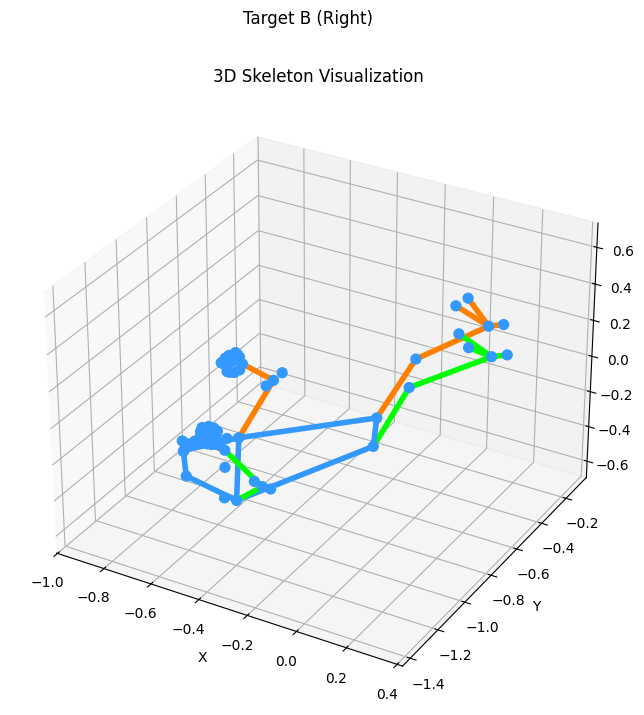

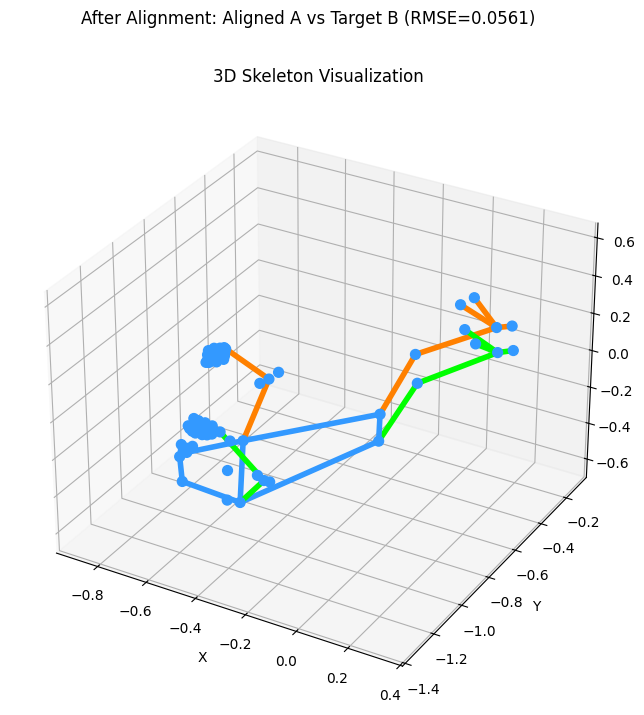

In [43]:
# Visualization of 3D point set alignment with Kabsch (SVD) in NumPy

import numpy as np
import json
import matplotlib.pyplot as plt

# =========================================================================
# 1) H36M 17 关键点骨架连线定义 (sam3d_body 常用)
# =========================================================================
# 定义骨架连线： (点a, 点b) 的索引对
# 关键点顺序通常基于 H36M 17 或其变体
H36M17_EDGES = np.array([
    [0, 1], [1, 2], [2, 3],  # 右腿: 盆骨-右髋-右膝-右脚
    [0, 4], [4, 5], [5, 6],  # 左腿: 盆骨-左髋-左膝-左脚
    [0, 7], [7, 8], [8, 9],  # 脊柱和头: 盆骨-脊柱-颈部-鼻子/头顶
    [8, 10], [10, 11], [11, 12],  # 左臂: 颈部-左肩-左肘-左手腕
    [8, 13], [13, 14], [14, 15]   # 右臂: 颈部-右肩-右肘-右手腕
    # 也可以添加头部连线，如 [9, 16] 鼻子到头顶
], dtype=np.int32)


# ---------- 2) Helper: rigid transform via SVD (Kabsch) ----------
def rigid_transform_3D(A, B):
    """
    Compute R, t that aligns Nx3 points A to B (minimizing least squares).
    A: Source points (Nx3)
    B: Target points (Nx3)
    Returns rotation matrix R (3x3) and translation t (3,).
    """
    assert A.shape == B.shape and A.shape[1] == 3

    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    # 居中化
    AA = A - centroid_A
    BB = B - centroid_B

    # 协方差矩阵 H
    H = AA.T @ BB
    # SVD
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # 处理反射 (如果确定是刚性变换，R的行列式必须是 +1)
    if np.linalg.det(R) < 0:
        # 反转 U 或 V 的其中一列/行
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # 计算平移向量
    t = centroid_B - R @ centroid_A
    return R, t

# =========================================================================
# 3) 创建合成示例 (模拟 sam3d_body 的 3D 关键点输入)
# =========================================================================

# 模拟 Ground Truth (Target B)
Lt_n = left_outputs[0]['pred_keypoints_3d']  # 使用左侧关键点作为目标 B
Rt_n = right_outputs[0]['pred_keypoints_3d']  # 使用右侧关键点作为源 A

print("left_outputs")
print(left_outputs[0]['pred_cam_t'])
print(left_outputs[0]['pred_global_rots'])

print("right_outputs")
print(right_outputs[0]['pred_cam_t'])
print(right_outputs[0]['pred_global_rots'])

# ---------- 4) 恢复变换并对齐 ----------
# 将 Source A (Lt_n) 对齐到 Target B (Rt_n)
R, t = rigid_transform_3D(Lt_n, Rt_n)
print("Rigid Transform:")
print(R, t)
A_aligned = (Lt_n @ R.T) + t

# 计算对齐误差 (RMSE)
rmse = np.sqrt(np.mean(np.sum((A_aligned - Rt_n)**2, axis=1)))


# Plot BEFORE alignment
fig1 = visualizer.draw_skeleton_3d(Lt_n)
fig1.suptitle('Left A (Before Alignment)')
plt.show()

fig2 = visualizer.draw_skeleton_3d(Rt_n)
fig2.suptitle('Target B (Right)')
plt.show()

# Plot AFTER alignment
fig2 = visualizer.draw_skeleton_3d(A_aligned)
fig2.suptitle(f'After Alignment: Aligned A vs Target B (RMSE={rmse:.4f})')
plt.show()


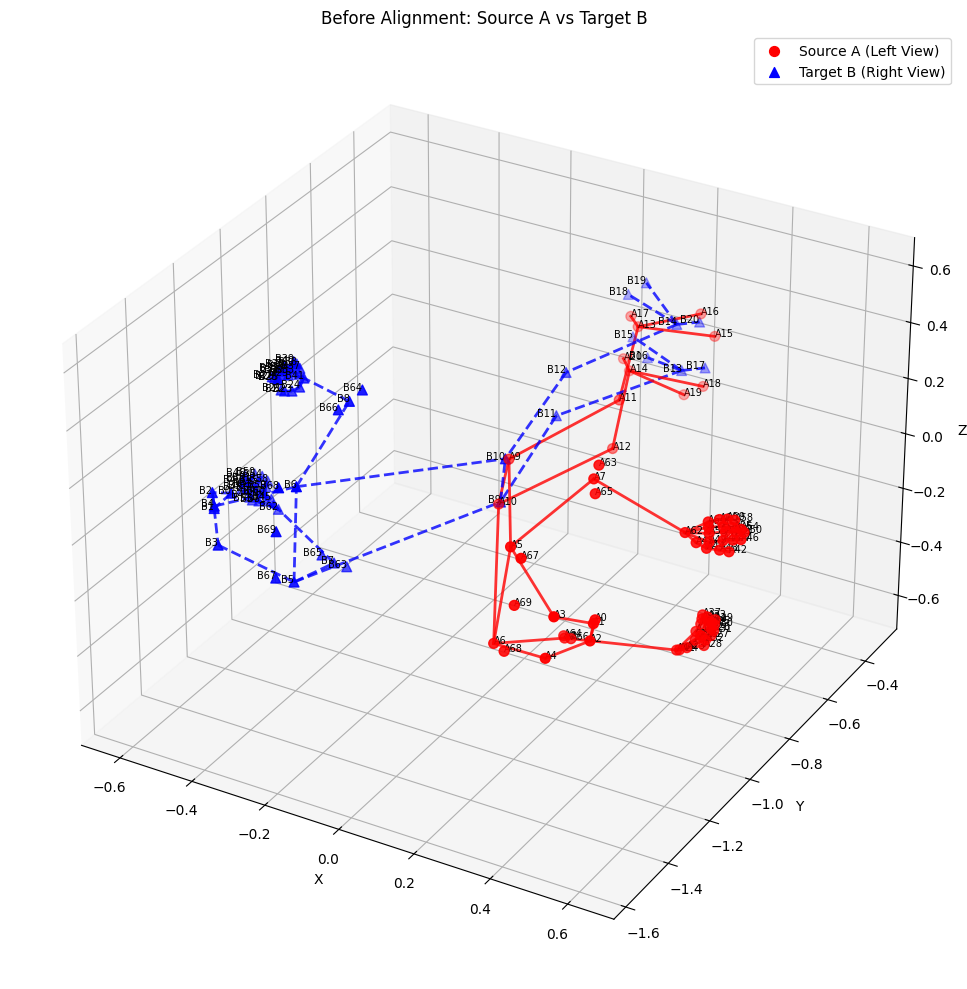

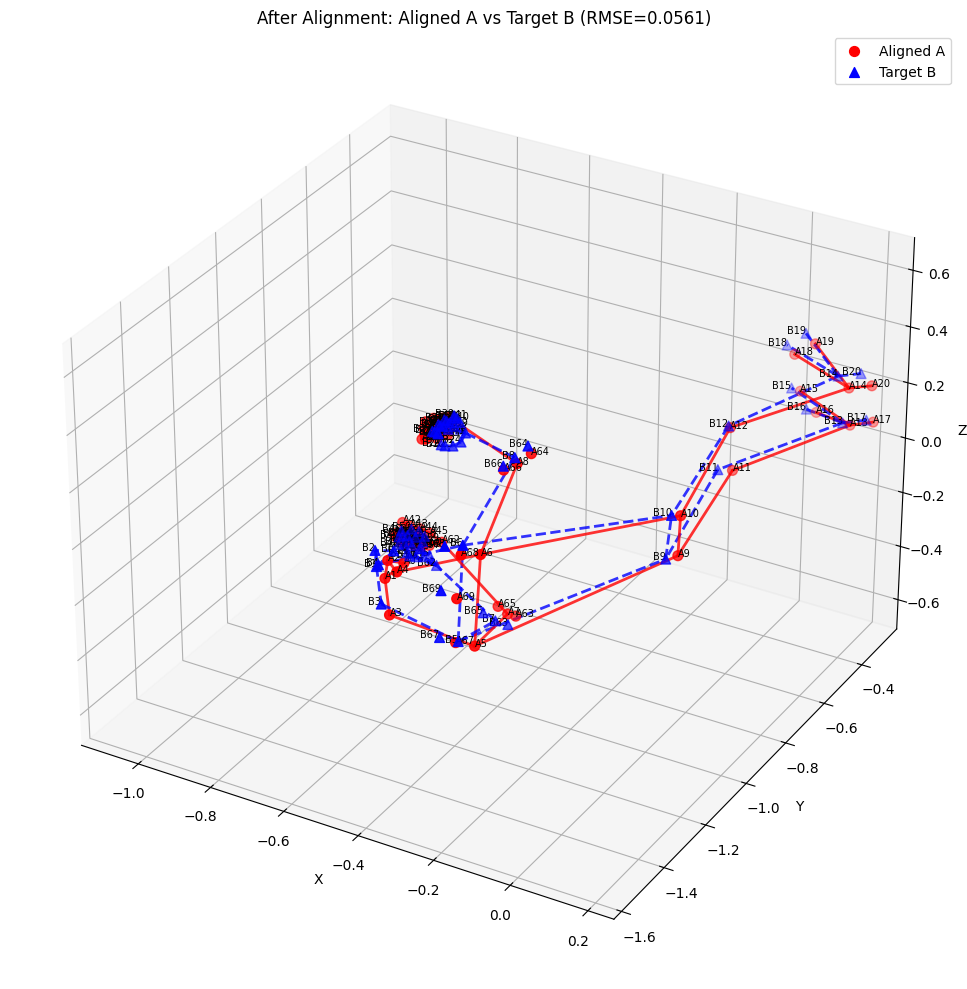

In [44]:
# Visualization of 3D point set alignment with Kabsch (SVD) in NumPy

import numpy as np
import json
import matplotlib.pyplot as plt

# =========================================================================
# 1) H36M 17 关键点骨架连线定义 (sam3d_body 常用)
# =========================================================================
# 定义骨架连线： (点a, 点b) 的索引对
H36M17_EDGES = np.array([
    [0, 1], [1, 2], [2, 3],  # 右腿: 盆骨-右髋-右膝-右脚
    [0, 4], [4, 5], [5, 6],  # 左腿: 盆骨-左髋-左膝-左脚
    [0, 7], [7, 8], [8, 9],  # 脊柱和头: 盆骨-脊柱-颈部-鼻子/头顶
    [8, 10], [10, 11], [11, 12],  # 左臂: 颈部-左肩-左肘-左手腕
    [8, 13], [13, 14], [14, 15]   # 右臂: 颈部-右肩-右肘-右手腕
], dtype=np.int32)


# ---------- 2) Helper: rigid transform via SVD (Kabsch) ----------
def rigid_transform_3D(A, B):
    # (此函数保持不变，省略代码以保持简洁)
    # ...
    assert A.shape == B.shape and A.shape[1] == 3

    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    AA = A - centroid_A
    BB = B - centroid_B

    H = AA.T @ BB
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    t = centroid_B - R @ centroid_A
    return R, t


# =========================================================================
# 3) 新增绘图函数：同时绘制两个 3D 骨架
# =========================================================================
def plot_3d_skeleton_alignment(A_data, B_data, edges, title, rmse=None, A_label='Source A', B_label='Target B', A_color='red', B_color='blue'):
    """在同一个 3D 图中绘制 Source A 和 Target B 骨架。"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    
    # 设置标题
    full_title = title
    if rmse is not None:
        full_title += f' (RMSE={rmse:.4f})'
    ax.set_title(full_title)
    
    # --- 绘制 Source A (点和线) ---
    ax.scatter(A_data[:,0], A_data[:,1], A_data[:,2], label=A_label, marker='o', c=A_color, s=50)
    
    # --- 绘制 Target B (点和线) ---
    ax.scatter(B_data[:,0], B_data[:,1], B_data[:,2], label=B_label, marker='^', c=B_color, s=50)

    # 绘制连线
    for a, b in edges:
        # Source A 骨架连线
        ax.plot([A_data[a, 0], A_data[b, 0]],
                [A_data[a, 1], A_data[b, 1]],
                [A_data[a, 2], A_data[b, 2]], c=A_color, alpha=0.8, linewidth=2)
        # Target B 骨架连线
        ax.plot([B_data[a, 0], B_data[b, 0]],
                [B_data[a, 1], B_data[b, 1]],
                [B_data[a, 2], B_data[b, 2]], c=B_color, alpha=0.8, linewidth=2, linestyle='--')
        
    # 标注点的索引（可选，如果点太多可注释掉）
    for i in range(A_data.shape[0]):
        # 标注 Source A 的索引
        ax.text(A_data[i, 0], A_data[i, 1], A_data[i, 2], f"A{i}", color='black', fontsize=7)
        # 标注 Target B 的索引
        ax.text(B_data[i, 0], B_data[i, 1], B_data[i, 2], f"B{i}", color='black', fontsize=7, ha='right')

    # 设置坐标轴标签和范围（保证比例一致）
    all_data = np.vstack([A_data, B_data])
    max_range = np.array([all_data[:, i].max() - all_data[:, i].min() for i in range(3)]).max() / 2.0
    mid = np.mean(all_data, axis=0)
    
    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)
    
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.legend()
    fig.tight_layout()
    return fig


# =========================================================================
# 4) 执行配准和绘图
# =========================================================================

# 模拟 Ground Truth (Target B) 和 Source A
Lt_n = left_outputs[0]['pred_keypoints_3d']    # Source A (预测结果，例如：左摄像头)
Rt_n = right_outputs[0]['pred_keypoints_3d']   # Target B (GT 或另一视图，例如：右摄像头)

# ---------- 配准计算 ----------
R, t = rigid_transform_3D(Lt_n, Rt_n)

# 对齐 Source A
A_aligned = (Lt_n @ R.T) + t

# 计算对齐误差 (RMSE)
rmse = np.sqrt(np.mean(np.sum((A_aligned - Rt_n)**2, axis=1)))


# ---------- 绘图展示 ----------

# 1. 配准前对比
fig_before = plot_3d_skeleton_alignment(
    Lt_n, Rt_n, 
    visualizer.skeleton, 
    title='Before Alignment: Source A vs Target B',
    A_label='Source A (Left View)',
    B_label='Target B (Right View)'
)
plt.show(fig_before)

# 2. 配准后对比 (重点查看 RMSE)
fig_after = plot_3d_skeleton_alignment(
    A_aligned, Rt_n, 
    visualizer.skeleton, 
    title='After Alignment: Aligned A vs Target B', 
    rmse=rmse,
    A_label='Aligned A',
    B_label='Target B'
)
plt.show(fig_after)

In [45]:

def plot_person_and_cameras(kpts_world, C_L_world, C_R_world,
                            edges=None, title="Person-centered world"):
    """
    kpts_world: (J, 3) 人体 3D 关键点（以骨盆为原点）
    C_L_world: (3,) 左相机在世界系的位置
    C_R_world: (3,) 右相机在世界系的位置
    edges: 骨架的边列表，例如 [(pelvis, hip_l), (hip_l, knee_l), ...]
    """
    kpts_world = np.asarray(kpts_world)
    C_L_world = np.asarray(C_L_world)
    C_R_world = np.asarray(C_R_world)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # ----- 1. 画骨架点 -----
    X, Y, Z = kpts_world[:, 0], kpts_world[:, 1], kpts_world[:, 2]
    ax.scatter(X, Y, Z, s=20)

    # 如果给了骨架拓扑，就画线连起来
    if edges is not None:
        for i, j in edges:
            xs = [kpts_world[i, 0], kpts_world[j, 0]]
            ys = [kpts_world[i, 1], kpts_world[j, 1]]
            zs = [kpts_world[i, 2], kpts_world[j, 2]]
            ax.plot(xs, ys, zs)

    # 在原点标记骨盆（假设第 0 个是骨盆，可以按你自己的索引改）
    ax.scatter([0], [0], [0], s=60)
    ax.text(0, 0, 0, "pelvis(0,0,0)")

    # ----- 2. 画相机位置 -----
    # 左相机
    ax.scatter(C_L_world[0], C_L_world[1], C_L_world[2], marker='^', s=80)
    ax.text(C_L_world[0], C_L_world[1], C_L_world[2], "Cam L")

    # 右相机
    ax.scatter(C_R_world[0], C_R_world[1], C_R_world[2], marker='s', s=80)
    ax.text(C_R_world[0], C_R_world[1], C_R_world[2], "Cam R")

    # （可选）画一条从相机指向人的线，表示视线大概方向
    ax.plot([C_L_world[0], 0], [C_L_world[1], 0], [C_L_world[2], 0])
    ax.plot([C_R_world[0], 0], [C_R_world[1], 0], [C_R_world[2], 0])

    # ----- 3. 设置坐标轴 -----

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)
    # 你可以在这里调整视角：
    # ax.view_init(elev=20, azim=-60)

    plt.show()

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


# ---------- 工具：保持 3D 坐标轴比例一致 ----------
def set_equal_3d(ax, X, Y, Z):
    max_range = np.array([
        X.max() - X.min(),
        Y.max() - Y.min(),
        Z.max() - Z.min()
    ]).max()
    Xb = 0.5 * (X.max() + X.min())
    Yb = 0.5 * (Y.max() + Y.min())
    Zb = 0.5 * (Z.max() + Z.min())
    ax.set_xlim(Xb - max_range / 2, Xb + max_range / 2)
    ax.set_ylim(Yb - max_range / 2, Yb + max_range / 2)
    ax.set_zlim(Zb - max_range / 2, Zb + max_range / 2)


# ---------- 计算相机视锥体的 4 个角点 ----------
def compute_frustum_points(C, forward, up=np.array([0, 1, 0]),
                           fov_deg=60, depth=1.0):
    """
    C       : (3,) 相机中心（世界系）
    forward : (3,) 相机朝向（需要归一化），例如朝向人物原点的方向
    up      : (3,) 粗略的“向上”方向向量
    fov_deg : 视野角度（大概给个 60° 即可）
    depth   : 视锥体长度（看多远）
    """
    C = np.asarray(C)
    forward = np.asarray(forward)
    forward = forward / (np.linalg.norm(forward) + 1e-8)

    right = np.cross(forward, up)
    right = right / (np.linalg.norm(right) + 1e-8)
    up = np.cross(right, forward)
    up = up / (np.linalg.norm(up) + 1e-8)

    h = depth * np.tan(np.radians(fov_deg) / 2.0)

    p_center = C + forward * depth
    p1 = p_center + right * h + up * h
    p2 = p_center - right * h + up * h
    p3 = p_center - right * h - up * h
    p4 = p_center + right * h - up * h

    return np.stack([p1, p2, p3, p4], axis=0)  # (4,3)


# ---------- 在 3D 里画视锥体 ----------
def draw_frustum(ax, C, frustum_pts, color='r'):
    C = np.asarray(C)
    # 相机中心到四个角点
    for p in frustum_pts:
        ax.plot([C[0], p[0]], [C[1], p[1]], [C[2], p[2]], color=color)

    # 四个角点围成的四边形
    idx = [0, 1, 2, 3, 0]
    for i in range(4):
        a = frustum_pts[idx[i]]
        b = frustum_pts[idx[i + 1]]
        ax.plot([a[0], b[0]], [a[1], b[1]], [a[2], b[2]], color=color)


# ---------- 主函数：画人物 + 左右相机 + 视锥体 ----------
def plot_scene(kpts_world, C_L_world, C_R_world,
               edges=None,
               fov_deg=60,
               frustum_depth=1.0,
			   elev=20, 
               azim=180,
               title="Person-centered world with two cameras"):
    """
    kpts_world : (J,3)  人体 3D 关键点（以骨盆为原点）
    C_L_world  : (3,)   左相机位置（世界系）
    C_R_world  : (3,)   右相机位置（世界系）
    edges      : list[(i,j)] 骨架拓扑，没给的话只画点
    fov_deg    : 视锥 FOV
    frustum_depth : 视锥长度
    """
    kpts_world = np.asarray(kpts_world)
    C_L_world = np.asarray(C_L_world)
    C_R_world = np.asarray(C_R_world)

    X = kpts_world[:, 0]
    Y = kpts_world[:, 1]
    Z = kpts_world[:, 2]

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    # --- 1. 人体骨架 ---
    ax.scatter(X, Y, Z, s=20)
    if edges is not None:
        for i, j in edges:
            xs = [kpts_world[i, 0], kpts_world[j, 0]]
            ys = [kpts_world[i, 1], kpts_world[j, 1]]
            zs = [kpts_world[i, 2], kpts_world[j, 2]]
            ax.plot(xs, ys, zs)

    # 标记骨盆为原点（假设 0 是骨盆）
    ax.scatter([0], [0], [0], s=60)
    ax.text(0, 0, 0, "pelvis(0,0,0)")

    # --- 2. 左相机 ---
    ax.scatter(C_L_world[0], C_L_world[1], C_L_world[2],
               marker='^', s=80, color='r')
    ax.text(C_L_world[0], C_L_world[1], C_L_world[2], "Cam L", color='r')

    # 朝向：默认看向人物原点
    dL = -C_L_world
    dL = dL / (np.linalg.norm(dL) + 1e-8)
    frustum_L = compute_frustum_points(C_L_world, dL,
                                       fov_deg=fov_deg,
                                       depth=frustum_depth)
    draw_frustum(ax, C_L_world, frustum_L, color='r')

    # --- 3. 右相机 ---
    ax.scatter(C_R_world[0], C_R_world[1], C_R_world[2],
               marker='s', s=80, color='b')
    ax.text(C_R_world[0], C_R_world[1], C_R_world[2], "Cam R", color='b')

    dR = -C_R_world
    dR = dR / (np.linalg.norm(dR) + 1e-8)
    frustum_R = compute_frustum_points(C_R_world, dR,
                                       fov_deg=fov_deg,
                                       depth=frustum_depth)
    draw_frustum(ax, C_R_world, frustum_R, color='b')

    # --- 4. 视线（相机到人）的连线（可选） ---
    ax.plot([C_L_world[0], 0], [C_L_world[1], 0], [C_L_world[2], 0],
            linestyle='--', color='r', alpha=0.5)
    ax.plot([C_R_world[0], 0], [C_R_world[1], 0], [C_R_world[2], 0],
            linestyle='--', color='b', alpha=0.5)

    # --- 5. 坐标轴 & 视角 ---
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)

    # 你可以在这里调一下默认视角：
    ax.view_init(elev=elev, azim=azim)

	
	# 翻转 Z 轴显示方向
    zmin, zmax = ax.get_zlim()
    ax.set_zlim(zmax, zmin)  # 上下限调换


    plt.tight_layout()
    plt.show()


In [47]:
import numpy as np
import plotly.graph_objects as go


def compute_frustum_points(C, forward, up=np.array([0, 1, 0]),
                           fov_deg=60, depth=1.0):
    """计算相机视锥体角点"""
    C = np.asarray(C)
    forward = forward / (np.linalg.norm(forward) + 1e-8)

    right = np.cross(forward, up)
    right = right / (np.linalg.norm(right) + 1e-8)
    up = np.cross(right, forward)
    up = up / (np.linalg.norm(up) + 1e-8)

    h = depth * np.tan(np.radians(fov_deg) / 2)

    p_center = C + forward * depth
    p1 = p_center + right * h + up * h
    p2 = p_center - right * h + up * h
    p3 = p_center - right * h - up * h
    p4 = p_center + right * h - up * h

    return np.stack([p1, p2, p3, p4], axis=0)


def plot_scene_interactive(kpts_world, C_L_world, C_R_world,
                           edges=None,
                           fov_deg=60,
                           frustum_depth=1.0,
                           title="Interactive 3D Scene (Person + Cameras)"):

    fig = go.Figure()

    # -------- 1. 绘制人体骨架 --------
    X, Y, Z = kpts_world[:,0], kpts_world[:,1], kpts_world[:,2]

    fig.add_trace(go.Scatter3d(
        x=X, y=Y, z=Z,
        mode='markers',
        marker=dict(size=4, color='black'),
        name="Joints"
    ))

    # 绘制骨架线条
    if edges is not None:
        for i, j in edges:
            fig.add_trace(go.Scatter3d(
                x=[kpts_world[i,0], kpts_world[j,0]],
                y=[kpts_world[i,1], kpts_world[j,1]],
                z=[kpts_world[i,2], kpts_world[j,2]],
                mode='lines',
                line=dict(color='black', width=3),
                name="bone",
                showlegend=False
            ))

    # -------- 2. 相机方向（默认朝向人体原点） --------
    dL = -C_L_world
    dL = dL / (np.linalg.norm(dL) + 1e-8)
    dR = -C_R_world
    dR = dR / (np.linalg.norm(dR) + 1e-8)

    # -------- 3. 相机视锥体 --------
    frustum_L = compute_frustum_points(C_L_world, forward=dL,
                                       fov_deg=fov_deg, depth=frustum_depth)

    frustum_R = compute_frustum_points(C_R_world, forward=dR,
                                       fov_deg=fov_deg, depth=frustum_depth)

    def add_frustum(fig, C, frustum_pts, color, name):
        # 从相机中心连到 4 个角
        for p in frustum_pts:
            fig.add_trace(go.Scatter3d(
                x=[C[0], p[0]], y=[C[1], p[1]], z=[C[2], p[2]],
                mode='lines',
                line=dict(color=color),
                showlegend=False
            ))
        # 连接四个角
        idx = [0,1,2,3,0]
        for i in range(4):
            a = frustum_pts[idx[i]]
            b = frustum_pts[idx[i+1]]
            fig.add_trace(go.Scatter3d(
                x=[a[0], b[0]], y=[a[1], b[1]], z=[a[2], b[2]],
                mode='lines',
                line=dict(color=color),
                showlegend=False
            ))
        # 画相机中心
        fig.add_trace(go.Scatter3d(
            x=[C[0]], y=[C[1]], z=[C[2]],
            mode='markers+text',
            marker=dict(size=5, color=color),
            text=[name],
            textposition="top center",
            name=name
        ))

    add_frustum(fig, C_L_world, frustum_L, color='red', name="Cam L")
    add_frustum(fig, C_R_world, frustum_R, color='blue', name="Cam R")

    # -------- 4. 布局设置 --------
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            aspectmode="data"
        ),
        width=900,
        height=900
    )

    fig.show()


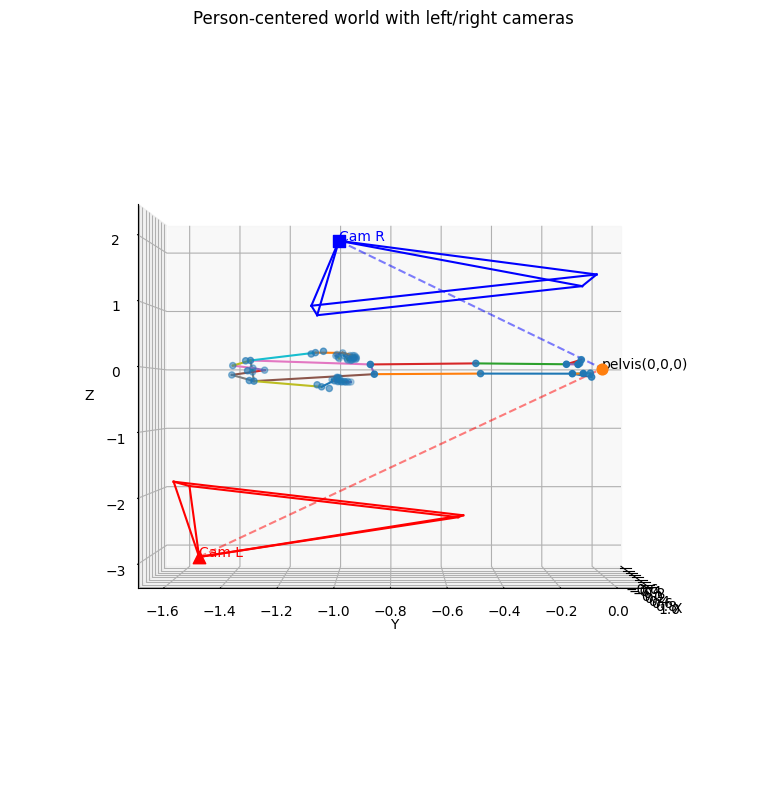

In [48]:
# kpts3d_left: (J,3)   左视角的 3D kpt（已经以骨盆对齐）
# pred_cam_t_left, pred_cam_t_right: (3,)
# s, R_RL, t_RL: 用 Umeyama 求出的 右→左 相似变换

# 世界系 = 左人系
s = 1.0
R_RL = R 
t_RL = t
# t_RL = right_outputs[0]['pred_cam_t'] # TODO：为什么直接用这个比较准确呢？刚体变换的 t_RL 不准确？

C_L_world = -left_outputs[0]['pred_cam_t']

C_R_person = -right_outputs[0]['pred_cam_t']
C_R_world = s * (R_RL @ C_R_person) + t_RL
# C_R_person[0] = -C_R_person[0]
# C_R_person[2] = -C_R_person[2]
# C_R_world = C_R_person


kpts_world = A_aligned  # 直接把左视角的人当作世界里的骨架

# 骨架拓扑按你自己的 joint 顺序来，这里只是例子
plot_scene(kpts_world, C_L_world, C_R_world,
           edges=visualizer.skeleton,
           fov_deg=60,
           frustum_depth=1.0,
           title="Person-centered world with left/right cameras")

plot_scene_interactive(kpts_world, C_L_world, C_R_world,
					   edges=visualizer.skeleton,fov_deg=60,
					   frustum_depth=1.0,
					   title="Interactive 3D Scene (Person + Cameras)")

raw_c_l_world: [0.48722696 1.5438714  4.5774894 ]
raw_c_r_world: [-0.16289183  1.0989265   4.0974045 ]
调整后 raw_c_l_world: [ 0.48722696 -1.5438714   4.5774894 ]
调整后 raw_c_r_world: [ 0.16289183 -1.0989265  -4.0974045 ]


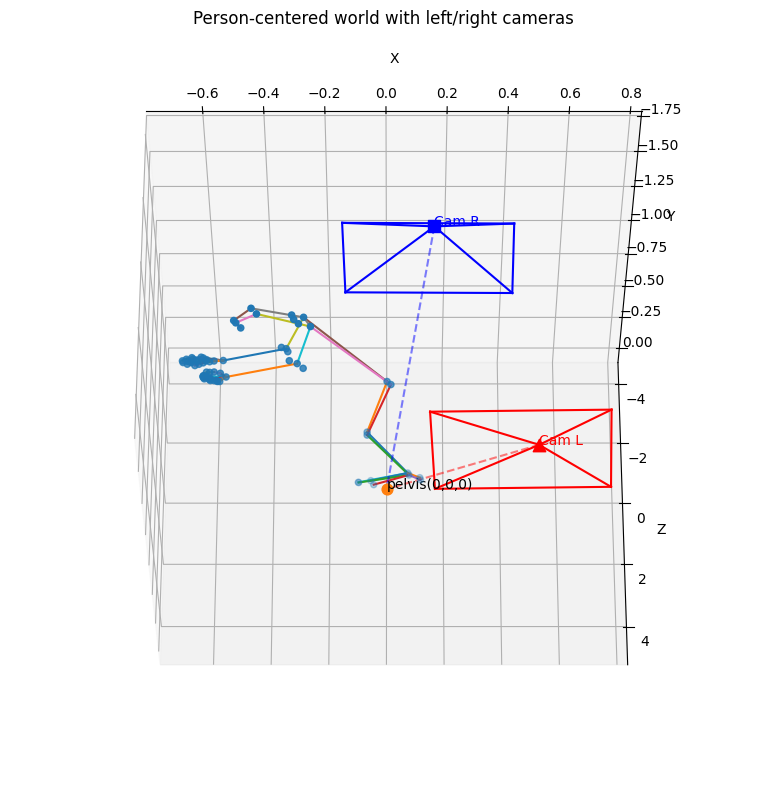

In [133]:
raw_c_l_world = left_outputs[105]['pred_cam_t']
raw_c_r_world = right_outputs[105]['pred_cam_t']
raw_kpts_world = left_outputs[105]['pred_keypoints_3d']

print("raw_c_l_world:", raw_c_l_world)
print("raw_c_r_world:", raw_c_r_world)

# 世界坐标是按照做相机的坐标系来定的
# 任务要求y轴向上，而做相机的y轴是向下的，所以两个相机都需要反转y轴
# 所以左相机的位置，只需要反转y
# 右相机的话，因为是根据z轴对称的，所以需要反转x，z轴，加上y轴的话，就是整体取反
raw_c_l_world[1] = -raw_c_l_world[1]
raw_c_r_world = -raw_c_r_world

# matplot 的z是反的
# raw_c_l_world[2] = -raw_c_l_world[2]
# raw_c_r_world[2] = -raw_c_r_world[2]

print("调整后 raw_c_l_world:", raw_c_l_world)
print("调整后 raw_c_r_world:", raw_c_r_world)

plot_scene(kpts_world, raw_c_l_world, raw_c_r_world,
           edges=visualizer.skeleton,
           fov_deg=60,
           frustum_depth=0.5,
           elev=-30,
           azim=270,
           title="Person-centered world with left/right cameras")

plot_scene_interactive(raw_kpts_world, raw_c_l_world, raw_c_r_world,
					   edges=visualizer.skeleton,fov_deg=60,
					   frustum_depth=0.5,
					   title="Interactive 3D Scene (Person + Cameras)")